In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/test_0_5565.jpeg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/test_0_2530.jpeg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-72.jpg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-30.jpg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-559.jpg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/test_0_4779.jpeg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-353.jpg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-524.jpg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/test_0_4352.jpeg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-251.jpg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/test_0_2070.jpeg
/kaggle/input/lungfinal/Lung Disease Dataset/test/Tuberculosis/test_0_6480.jpeg
/kaggle/input/lung

Found 6861 images belonging to 5 classes.
Found 2032 images belonging to 5 classes.


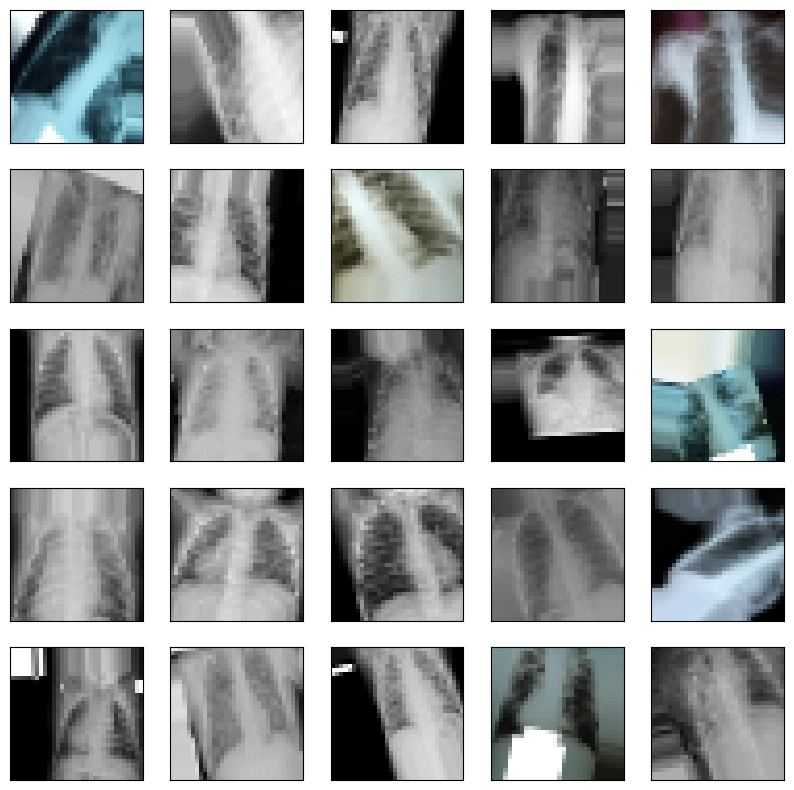

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define the image dimensions and number of classes
num_classes = 5  # Replace with the number of classes in your dataset
input_shape = (32, 32, 3)

# Define the paths to your 'sazzat' dataset
train_dir = '/kaggle/input/lungfinal/Lung Disease Dataset/train'
test_dir = '/kaggle/input/lungfinal/Lung Disease Dataset/test'

# Create data generators for training and testing
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for the test set

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],  # Resize images to match 'input_shape'
    batch_size=batch_size,
    class_mode='categorical'  # Assumes you have multiple classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

# Optionally, you can visualize some images from the training set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    batch = train_generator.next()
    image = batch[0][0]
    plt.imshow(image)
plt.show()


In [13]:
import tensorflow as tf
from tensorflow.keras import layers

# Now, 'layers' is defined and can be used in your code.

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-4
batch_size = 32
num_epochs = 30
validation_split = 0.1
weight_decay = 1e-4
label_smoothing = 0.2
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patch_height, patch_width = self.patch_size  # Unpack the tuple
        patch_num_y = 32 // patch_height
        patch_num_x = 32 // patch_width
        patch_dim = patch_height * patch_width * 3  # Adjust for your input shape
        patches = tf.image.extract_patches(
            images,
            sizes=[1, patch_height, patch_width, 1],
            strides=[1, patch_height, patch_width, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        return tf.reshape(patches, (batch_size, patch_num_y * patch_num_x, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)
import tensorflow_addons as tfa
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)


In [14]:
epochs=30
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)



Epoch 1/30
215/215 [==============================] - 115s 512ms/step - loss: 1.5226 - accuracy: 0.3553 - top-5-accuracy: 1.0000 - val_loss: 1.4332 - val_accuracy: 0.4360 - val_top-5-accuracy: 1.0000
Epoch 2/30
215/215 [==============================] - 110s 512ms/step - loss: 1.4094 - accuracy: 0.4429 - top-5-accuracy: 1.0000 - val_loss: 1.3538 - val_accuracy: 0.5344 - val_top-5-accuracy: 1.0000
Epoch 3/30
215/215 [==============================] - 132s 612ms/step - loss: 1.3580 - accuracy: 0.4950 - top-5-accuracy: 1.0000 - val_loss: 1.3047 - val_accuracy: 0.5797 - val_top-5-accuracy: 1.0000
Epoch 4/30
215/215 [==============================] - 131s 609ms/step - loss: 1.3413 - accuracy: 0.5084 - top-5-accuracy: 1.0000 - val_loss: 1.2922 - val_accuracy: 0.5822 - val_top-5-accuracy: 1.0000
Epoch 5/30
215/215 [==============================] - 111s 518ms/step - loss: 1.3175 - accuracy: 0.5295 - top-5-accuracy: 1.0000 - val_loss: 1.2422 - val_accuracy: 0.6088 - val_top-5-accuracy: 1.0000


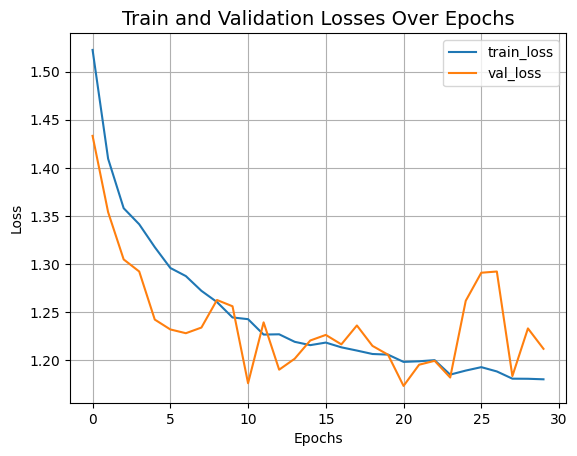

In [15]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

64/64 [==============================] - 21s 321ms/step


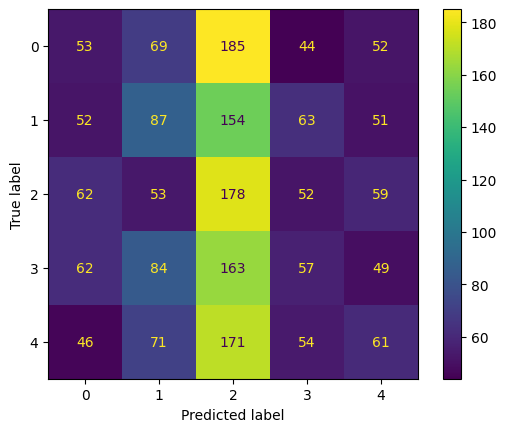

In [16]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Make predictions on the test data
y_pred = model.predict(test_generator)

# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

# Display the confusion matrix
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [17]:
from tensorflow.keras.callbacks import TensorBoard
epochs=7
# Create a TensorBoard callback
tb_callback = TensorBoard(log_dir='logs')

# Train the model with the TensorBoard callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[tb_callback]
)

Epoch 1/7
215/215 [==============================] - 111s 514ms/step - loss: 1.1817 - accuracy: 0.6470 - top-5-accuracy: 1.0000 - val_loss: 1.1940 - val_accuracy: 0.6142 - val_top-5-accuracy: 1.0000
Epoch 2/7
215/215 [==============================] - 108s 503ms/step - loss: 1.1727 - accuracy: 0.6550 - top-5-accuracy: 1.0000 - val_loss: 1.1973 - val_accuracy: 0.6235 - val_top-5-accuracy: 1.0000
Epoch 3/7
215/215 [==============================] - 111s 514ms/step - loss: 1.1871 - accuracy: 0.6419 - top-5-accuracy: 1.0000 - val_loss: 1.2118 - val_accuracy: 0.5965 - val_top-5-accuracy: 1.0000
Epoch 4/7
215/215 [==============================] - 110s 511ms/step - loss: 1.1860 - accuracy: 0.6336 - top-5-accuracy: 1.0000 - val_loss: 1.2225 - val_accuracy: 0.6063 - val_top-5-accuracy: 1.0000
Epoch 5/7
215/215 [==============================] - 113s 523ms/step - loss: 1.1754 - accuracy: 0.6498 - top-5-accuracy: 1.0000 - val_loss: 1.2111 - val_accuracy: 0.6048 - val_top-5-accuracy: 1.0000
Epoch

In [18]:
from tensorflow.keras.callbacks import TensorBoard
epochs=10
# Create a TensorBoard callback
tb_callback = TensorBoard(log_dir='logs')

# Train the model with the TensorBoard callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[tb_callback]
)

Epoch 1/10
215/215 [==============================] - 110s 510ms/step - loss: 1.1795 - accuracy: 0.6455 - top-5-accuracy: 1.0000 - val_loss: 1.1670 - val_accuracy: 0.6348 - val_top-5-accuracy: 1.0000
Epoch 2/10
215/215 [==============================] - 109s 506ms/step - loss: 1.1691 - accuracy: 0.6514 - top-5-accuracy: 1.0000 - val_loss: 1.1918 - val_accuracy: 0.6457 - val_top-5-accuracy: 1.0000
Epoch 3/10
215/215 [==============================] - 109s 506ms/step - loss: 1.1772 - accuracy: 0.6533 - top-5-accuracy: 1.0000 - val_loss: 1.1820 - val_accuracy: 0.6378 - val_top-5-accuracy: 1.0000
Epoch 4/10
215/215 [==============================] - 164s 765ms/step - loss: 1.1760 - accuracy: 0.6483 - top-5-accuracy: 1.0000 - val_loss: 1.1336 - val_accuracy: 0.6781 - val_top-5-accuracy: 1.0000
Epoch 5/10
215/215 [==============================] - 145s 676ms/step - loss: 1.1721 - accuracy: 0.6528 - top-5-accuracy: 1.0000 - val_loss: 1.1305 - val_accuracy: 0.6973 - val_top-5-accuracy: 1.0000


64/64 [==============================] - 20s 316ms/step


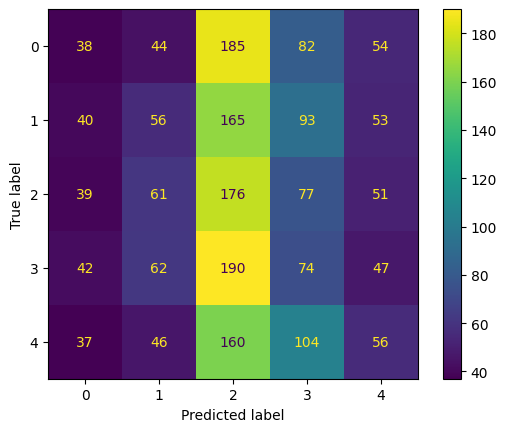

In [19]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Make predictions on the test data
y_pred = model.predict(test_generator)

# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

# Display the confusion matrix
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test data
y_pred = model.predict(test_generator)

# Calculate the precision, recall, and F1 score values
precision = precision_score(test_generator.classes, np.argmax(y_pred, axis=1), average='micro')
recall = recall_score(test_generator.classes, np.argmax(y_pred, axis=1), average='micro')
f1_score = f1_score(test_generator.classes, np.argmax(y_pred, axis=1), average='micro')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)



64/64 [==============================] - 20s 316ms/step
Precision: 0.20718503937007873
Recall: 0.20718503937007873
F1 score: 0.20718503937007873


In [17]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

# Calculate the precision, recall, and F1 score values for each class
precision = np.diagonal(cm) / np.sum(cm, axis=1)
recall = np.diagonal(cm) / np.sum(cm, axis=0)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)


Precision: [0.24813896 0.15724816 0.07673267 0.20481928 0.26550868]
Recall: [0.18832392 0.17582418 0.18787879 0.20238095 0.19384058]
F1 score: [0.21413276 0.16601816 0.10896309 0.20359281 0.22408377]


In [21]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Make predictions on the test data
y_pred = model.predict(test_generator)

# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

# Get the true negative, false negative, true positive, and false negative values
results = {}
for i in range(4):
    results[f'True negative' if i == 0 else f'False negative' if i == 1 else f'True positive' if i == 2 else f'False positive'] = cm.ravel()[i]

# Display the values
for metric, value in results.items():
    print(f'{metric}: {value}')


64/64 [==============================] - 21s 317ms/step
True negative: 24
False negative: 68
True positive: 172
False positive: 89


64/64 [==============================] - 20s 313ms/step


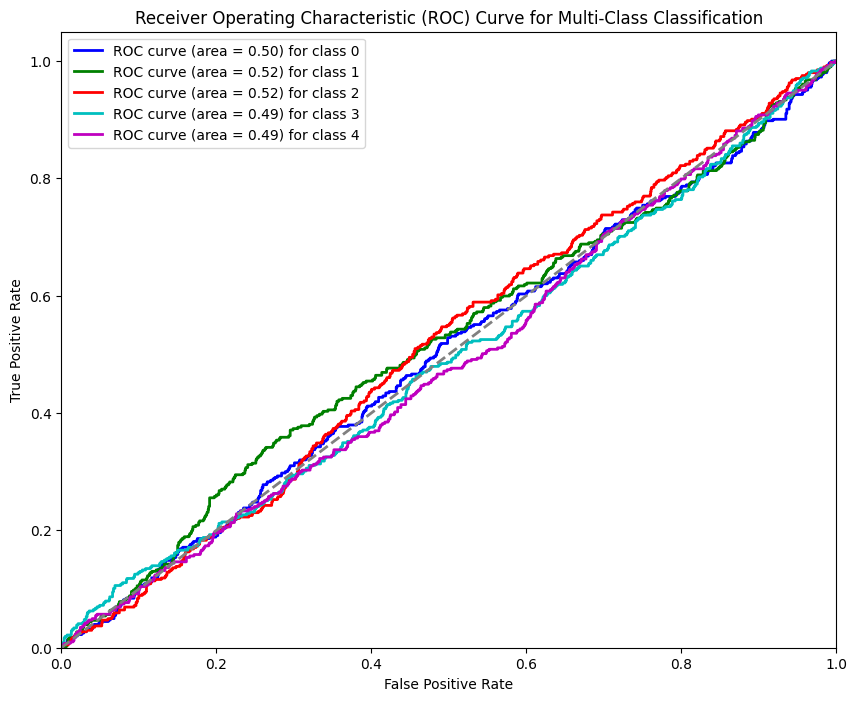

In [24]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have your test data and model predictions
y_true = test_generator.classes  # True class labels (not one-hot encoded)
y_prob = model.predict(test_generator)  # Predicted probabilities

n_classes = len(test_generator.class_indices)

# Initialize variables to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm']  # You can add more colors if needed
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class Classification')
plt.legend(loc='best')
plt.show()
